# NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis

Official: [paper](https://arxiv.org/abs/2003.08934) [project](https://www.matthewtancik.com/nerf) [code](https://github.com/bmild/nerf)
  
https://zhuanlan.zhihu.com/p/482154458
> This notebook is created [kunkun0w0](https://github.com/kunkun0w0/Easy-Torch-NeRF) and is a faithful PyTorch implementation of NeRF based on the official code, which aims to assist reseachers interested in this areas to reproduce from scratch.<br>
In this tutorial, I just use Lego data provided by the official project to keep the code clear and accessible.<br>
Hope you enjoy it. 🥳🥳🥳





## Download Tiny Lego

The 'npz' data contains the focal lenght of the camera, the images captured by cameras and the camera poses when capturing.

>images.shape : (106, 100, 100, 3) => 106 RGB images with the size of 100*100<br>
poses.shape  : (106, 4, 4) => these (4,4) matrixes are the transform matrixes from camera to world<br>
focal lenght : 138.88887889922103

In this project we use 100 RGB Lego images for training.


images.shape: (106, 100, 100, 3)
poses.shape: (106, 4, 4)
focal: 138.88887889922103


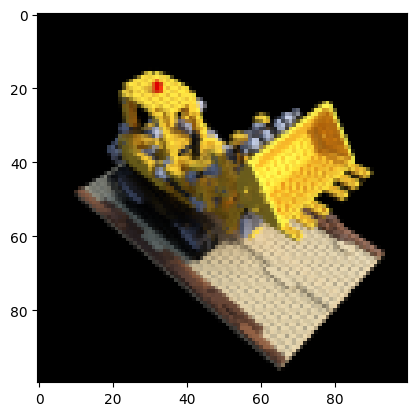

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.nn.functional as F
from tqdm import tqdm


if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(999)
np.random.seed(666)
torch.backends.cudnn.benchmark=True

data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print("images.shape:", images.shape)
print("poses.shape:", poses.shape)
print("focal:", focal)

n_train = 100 # use n_train images for training

test_img, test_pose = images[101], poses[101]
images = images[:n_train]
poses = poses[:n_train]

plt.imshow(test_img)
plt.show()

## Create NeRF

The network architecture is illustrated in the Fig.1 in the Appendix of the original paper.

And I add a black arrow to make it clear to see that σ is generated by a extra linear lay with relu activation.

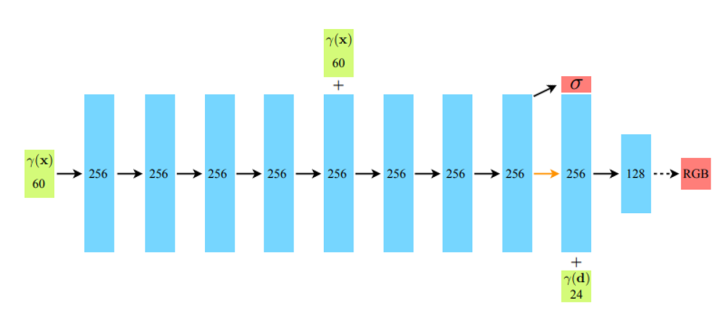

> All layers are standard fully-connected layers, black arrows indicate layers with ReLU activations, orange arrows indicate layers with no activation, dashed black arrows indicate layers with sigmoid activation, and “+” denotes vector concatenation. The positional encoding of the input location (γ(x)) is passed through 8 fully-connected ReLU layers, each with 256 channels. An additional layer outputs the volume density σ (which is rectified using a ReLU to ensure that the output volume density is nonnegative) and a 256-dimensional feature vector. This feature vector is concatenated with the positional encoding of the input viewing direction (γ(d)), and is processed by an additional fully-connected ReLU layer with 128 channels. A final layer (with a sigmoid activation) outputs the emitted RGB radiance at position x, as viewed by a ray with direction d.

In [32]:
class NeRF(nn.Module):
    def __init__(self, D=8, W=256, input_ch=60, input_ch_views=24, skip=4, use_view_dirs=True):
        super(NeRF, self).__init__()
        self.D = D
        self.W = W
        self.input_ch = input_ch
        self.input_ch_views = input_ch_views
        self.skip = skip
        self.use_view_dirs = use_view_dirs

        self.net = nn.ModuleList([nn.Linear(input_ch, W)])
        for i in range(D-1):
            if i == skip:
                self.net.append(nn.Linear(W + input_ch, W))
            else:
                self.net.append(nn.Linear(W, W))

        self.alpha_linear = nn.Linear(W, 1)
        self.feature_linear = nn.Linear(W, W)
        if use_view_dirs:
            self.proj = nn.Linear(W + input_ch_views, W // 2)
        else:
            self.proj = nn.Linear(W, W // 2)
        self.rgb_linear = nn.Linear(W // 2, 3)

    def forward(self, input_pts, input_views=None):
        h = input_pts.clone()
        for i, _ in enumerate(self.net):
            h = F.relu(self.net[i](h))
            if i == self.skip:
                h = torch.cat([input_pts, h], -1)

        alpha = F.relu(self.alpha_linear(h))
        feature = self.feature_linear(h)

        if self.use_view_dirs:
            h = torch.cat([feature, input_views], -1)

        h = F.relu(self.proj(h))
        rgb = torch.sigmoid(self.rgb_linear(h))

        return rgb, alpha

## Position Encoding

It is interpret in section 5.1 in the original paper.

I leave out $\pi$, compared with eq.4 in the original paper.

In [33]:
def PE(x, L):
  pe = []
  pai = 3.14
  for i in range(L):
    for fn in [torch.sin, torch.cos]:
      pe.append(fn(2.**i * x))
  return torch.cat(pe, -1)


## Sampling

### Sample Rays

For volume rendering, we need to get the dirction of the ray in the real world.

So we can first calculate the ray direction in camera space from screen space, then use the camera-to-wolrd matrix to transform the direction in the world space.

The transform process is illustrated as follow.

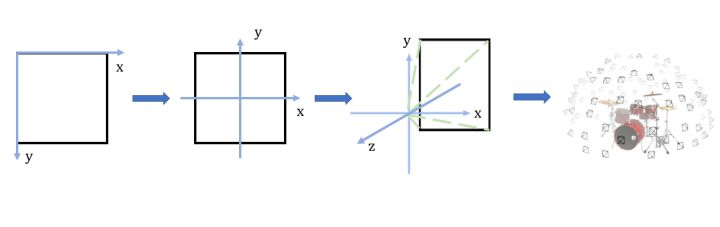

In [34]:
def sample_rays_np(H, W, f, c2w):
    i, j = np.meshgrid(np.arange(W, dtype=np.float32), np.arange(H, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-W*.5+.5)/f, -(j-H*.5+.5)/f, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., None, :] * c2w[:3,:3], -1)
    rays_o = np.broadcast_to(c2w[:3,-1], np.shape(rays_d))
    return rays_o, rays_d

### Sample Points

In this paper, they propose the Hierarchical Sampling to get the points that significantly contribute to the result.

#### Uniform Sampling

First, we do uniform sampling on each sector along the rays to get points for rendering or inquiring the weights distribution which is required by Hierarchical Sampling.

In [35]:
def uniform_sample_point(tn, tf, N_samples, device):
    k = torch.rand([N_samples], device=device) / float(N_samples)
    pt_value = torch.linspace(0.0, 1.0, N_samples + 1, device=device)[:-1]
    pt_value += k
    return tn + (tf - tn) * pt_value

#### Hierarchical Sampling

It is interpreted in section 5.2 in the original paper.

We use an inverse transform sampling get 'fine' points from the 'coarse' distribution, i.e., the weights distibution of the Uniform Sampling points.

In [36]:
# Hierarchical sampling (section 5.2)
def sample_pdf_point(bins, weights, N_samples, device):
    pdf = F.normalize(weights, p=1, dim=-1)
    cdf = torch.cumsum(pdf, -1)
    cdf = torch.cat([torch.zeros_like(cdf[..., :1]), cdf], -1)

    # uniform sampling
    u = torch.rand(list(cdf.shape[:-1]) + [N_samples], device=device).contiguous()

    # invert
    ids = torch.searchsorted(cdf, u, right=True)
    below = torch.max(torch.zeros_like(ids - 1, device=device), ids - 1)
    above = torch.min((cdf.shape[-1] - 1) * torch.ones_like(ids, device=device), ids)
    ids_g = torch.stack([below, above], -1)
    # ids_g => (batch, N_samples, 2)

    # matched_shape : [batch, N_samples, bins]
    matched_shape = [ids_g.shape[0], ids_g.shape[1], cdf.shape[-1]]
    # gather cdf value
    cdf_val = torch.gather(cdf.unsqueeze(1).expand(matched_shape), -1, ids_g)
    # gather z_val
    bins_val = torch.gather(bins[None, None, :].expand(matched_shape), -1, ids_g)

    # get z_val for the fine sampling
    cdf_d = (cdf_val[..., 1] - cdf_val[..., 0])
    cdf_d = torch.where(cdf_d < 1e-5, torch.ones_like(cdf_d, device=device), cdf_d)
    t = (u - cdf_val[..., 0]) / cdf_d
    samples = bins_val[..., 0] + t * (bins_val[..., 1] - bins_val[..., 0])

    return samples

## Volume Rendering

We use NN to implicitly store the RGBA of the point in the world space.

And use the volume rendering equation to fitting the image we captured from the world space with known camera pose.


### Run NN

use nerual network to get the weight and RGB for rendering.

In [37]:
def get_rgb_w(net, pts, rays_d, z_vals, device, noise_std=.0, use_view=False):
    # pts => tensor(Batch_Size, uniform_N, 3)
    # rays_d => tensor(Batch_Size, 3)
    # Run network
    pts_flat = torch.reshape(pts, [-1, 3])
    pts_flat = PE(pts_flat, L=10)
    dir_flat = None
    if use_view:
        dir_flat = F.normalize(torch.reshape(rays_d.unsqueeze(-2).expand_as(pts), [-1, 3]), p=2, dim=-1)
        dir_flat = PE(dir_flat, L=4)

    rgb, sigma = net(pts_flat, dir_flat)
    rgb = rgb.view(list(pts.shape[:-1]) + [3])
    sigma = sigma.view(list(pts.shape[:-1]))

    # get the interval
    delta = z_vals[..., 1:] - z_vals[..., :-1]
    INF = torch.ones(delta[..., :1].shape, device=device).fill_(1e10)
    delta = torch.cat([delta, INF], -1)
    delta = delta * torch.norm(rays_d, dim=-1, keepdim=True)

    # add noise to sigma
    if noise_std > 0.:
        sigma += torch.randn(sigma.size(), device=device) * noise_std

    # get weights
    alpha = 1. - torch.exp(-sigma * delta)
    ones = torch.ones(alpha[..., :1].shape, device=device)
    weights = alpha * torch.cumprod(torch.cat([ones, 1. - alpha], dim=-1), dim=-1)[..., :-1]

    return rgb, weights

### Sample and Render

This the main process of Neural Rendering.

For saving GPU, I just use a network to sample twice when applying Hierarchical Sampling.

Feel free to add the coarse network optimizing process to align the design of the original NeRF.

In [38]:
def render_rays(net, rays, bound, N_samples, device, noise_std=.0, use_view=False):
    rays_o, rays_d = rays
    bs = rays_o.shape[0]
    near, far = bound
    uniform_N, important_N = N_samples
    z_vals = uniform_sample_point(near, far, uniform_N, device)
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., None]
    # pts => tensor(Batch_Size, uniform_N, 3)
    # rays_o, rays_d => tensor(Batch_Size, 3)

    # Run network
    if important_N is not None:
        with torch.no_grad():
            rgb, weights = get_rgb_w(net, pts, rays_d, z_vals, device, noise_std=noise_std, use_view=use_view)
            z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
            samples = sample_pdf_point(z_vals_mid, weights[..., 1:-1], important_N, device)

        z_vals = z_vals.unsqueeze(0).expand([bs, uniform_N])
        z_vals, _ = torch.sort(torch.cat([z_vals, samples], dim=-1), dim=-1)
        pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., None]

    rgb, weights = get_rgb_w(net, pts, rays_d, z_vals, device, noise_std=noise_std, use_view=use_view)

    rgb_map = torch.sum(weights[..., None] * rgb, dim=-2)
    depth_map = torch.sum(weights * z_vals, -1)
    acc_map = torch.sum(weights, -1)

    return rgb_map, depth_map, acc_map

## Train the model

### Create Rays Data

To batchify the rays, for each ray, we have to get its direction, origin and color.

In [39]:
print("Process rays data!")
rays_o_list = list()
rays_d_list = list()
rays_rgb_list = list()

for i in range(n_train):
    img = images[i]
    pose = poses[i]
    rays_o, rays_d = sample_rays_np(H, W, focal, pose)

    rays_o_list.append(rays_o.reshape(-1, 3))
    rays_d_list.append(rays_d.reshape(-1, 3))
    rays_rgb_list.append(img.reshape(-1, 3))

rays_o_npy = np.concatenate(rays_o_list, axis=0)
rays_d_npy = np.concatenate(rays_d_list, axis=0)
rays_rgb_npy = np.concatenate(rays_rgb_list, axis=0)
rays = torch.tensor(np.concatenate([rays_o_npy, rays_d_npy, rays_rgb_npy], axis=1), device=device)
# rays => tensor(N_rays, 9) => o+d+rgb

Process rays data!


### Training Process

For every iteration, we sample 4096 rays for training.

And we sample 64 points for rendering.

If you want to use Hierarchical Sampling, just set the second value of `N_samples`.

Training Epoches: 10

Adam Learning rate: 5e-4

This notebook just cost ∼5GB Video Memory and ∼15mins to train (w/o Hierarchical Sampling).

In [40]:
#############################
# training parameters
#############################
N = rays.shape[0]
Batch_size = 4096
iterations = N // Batch_size
print(f"There are {iterations} batches of rays and each batch contains {Batch_size} rays")

bound = (2., 6.)
N_samples = (64, None)
use_view = True
epoch = 10
psnr_list = []
e_nums = []

#############################
# test data
#############################
test_rays_o, test_rays_d = sample_rays_np(H, W, focal, test_pose)
test_rays_o = torch.tensor(test_rays_o, device=device)
test_rays_d = torch.tensor(test_rays_d, device=device)
test_rgb = torch.tensor(test_img, device=device)


#############################
# training
#############################
net = NeRF(use_view_dirs=use_view).to(device)
optimizer = torch.optim.Adam(net.parameters(), 5e-4)
mse = torch.nn.MSELoss()

for e in range(epoch):
    # create iteration for training
    rays = rays[torch.randperm(N), :]
    train_iter = iter(torch.split(rays, Batch_size, dim=0))

    # render + mse
    with tqdm(total=iterations, desc=f"Epoch {e+1}", ncols=100) as p_bar:
        for i in range(iterations):
            train_rays = next(train_iter)
            assert train_rays.shape == (Batch_size, 9)

            rays_o, rays_d, target_rgb = torch.chunk(train_rays, 3, dim=-1)
            rays_od = (rays_o, rays_d)
            rgb, _, __ = render_rays(net, rays_od, bound=bound, N_samples=N_samples, device=device, use_view=use_view)

            loss = mse(rgb, target_rgb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            p_bar.set_postfix({'loss': '{0:1.5f}'.format(loss.item())})
            p_bar.update(1)

    with torch.no_grad():
        rgb_list = list()
        for j in range(test_rays_o.shape[0]):
            rays_od = (test_rays_o[j], test_rays_d[j])
            rgb, _, __ = render_rays(net, rays_od, bound=bound, N_samples=N_samples, device=device, use_view=use_view)
            rgb_list.append(rgb.unsqueeze(0))
        rgb = torch.cat(rgb_list, dim=0)
        loss = mse(rgb, torch.tensor(test_img, device=device)).cpu()
        psnr = -10. * torch.log(loss).item() / torch.log(torch.tensor([10.]))
        print(f"PSNR={psnr.item()}")
        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(rgb.cpu().detach().numpy())
        plt.title(f'Epoch: {e + 1}')
        plt.subplot(122)

        e_nums.append(e+1)
        psnr_list.append(psnr.numpy())
        plt.plot(e_nums, psnr_list)
        plt.title('PSNR')
        plt.show()

print('Done')

There are 244 batches of rays and each batch contains 4096 rays


Epoch 1:  62%|███████████████████████▌              | 151/244 [01:15<00:46,  2.00it/s, loss=0.02429]


KeyboardInterrupt: 

## Render 360 Video

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=float)

rot_phi = lambda phi : np.array([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=float)

rot_theta = lambda th : np.array([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=float)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = sample_rays_np(H, W, focal, c2w[:3,:4])
    with torch.no_grad():
      rays_o = torch.tensor(rays_o, device=device)
      rays_d = torch.tensor(rays_d, device=device)
      rgb_list = list()
      for j in range(rays_o.shape[0]):
        rays_od = (rays_o[j], rays_d[j])
        rgb, _, __ = render_rays(net, rays_od, bound=bound, N_samples=N_samples, device=device, use_view=use_view)
        rgb_list.append(rgb.unsqueeze(0))
      rgb = torch.cat(rgb_list, dim=0)

    plt.figure(2, figsize=(20,6))
    plt.imshow(rgb.cpu().detach().numpy())
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

# interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
# interactive_plot

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    with torch.no_grad():
      c2w = pose_spherical(th, -30., 4.)
      rays_o, rays_d = sample_rays_np(H, W, focal, c2w[:3,:4])
      rays_od = (torch.tensor(rays_o, device=device,dtype=torch.float32),torch.tensor(rays_d, device=device,dtype=torch.float32))
      rgb, depth, acc = render_rays(net, rays_od, bound=bound, N_samples=N_samples, device=device, use_view=use_view)
    frames.append((255*np.clip(rgb.cpu().numpy(),0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)